## Text Exploration and Classification with Naive Bayes
### Anna Chen - Data Science Project
- Goal: Complete the tasks outlined in this python notebook.
- Python notebook outline created by Marcus Gubanyi.

In [1]:
# import libraries

# Data Handling and Analysis
import pandas as pd
import numpy as np

# Text Processing and NLP
import re
from collections import Counter # Tocenization
import nltk
nltk.download('punkt') # for sentence and word tokenization
nltk.download('stopwords')
nltk.download('wordnet') # for lemmatization - reduces words to their base or root form
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Machine Learning, Vectorization, and cross validation 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.sparse import issparse # to check if vectorized data is sparse

# Word Cloud and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Advanced Vectorization
from gensim.models import Word2Vec

# Transformers for BERT and GPT
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel, pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\s9602\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
from datetime import datetime

# Function to print the current timestamp -> help keep track of my work
def print_timestamp(message=""):
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    print(f"{message}Timestamp: {current_time}")

# Example usage
# some process here
print_timestamp("Process finished. ")

Process finished. Timestamp: 2024-12-06 14:08:49


### The Pipeline in Hugging Face Transformers
An abstraction that simplifies the usage of pre-trained models for various natural language processing tasks. It handles the entire process, including tokenization, model inference, and post-processing, allowing you to perform tasks with just a few lines of code. Essentially, it’s a high-level API that wraps the complexities of model loading and inference.

### Key Features of Hugging Face Pipelines:
- **Simplified Usage:** Pipelines provide an easy-to-use interface to perform common NLP tasks such as text classification, sentiment analysis, text generation, named entity recognition, etc.
- **Pre-processing and Post-processing:** Pipelines take care of the necessary pre-processing (e.g., tokenizing the input text) and post-processing (e.g., converting model outputs to human-readable results).
- **Unified Interface:** Regardless of the underlying model or task, the interface remains consistent, making it easier to switch between different tasks and models.

info by Microsoft Copilot

### TASK 1: Load Training Dataset (3 points)
Acquire the dataset from the following link.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset Citation:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).


In [40]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')

# Display the first few rows of the dataset to check it's loaded correctly
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# Check for missing values 
missing_values = df.isnull().sum() 
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 review       0
sentiment    0
dtype: int64


### TASK 2: Create a binary target column named "class" (2 points)
"negative" -> 0
"positive" -> 1

Hint: Use the apply function.

In [41]:
# function to convert sentiment to a binary class
def sentiment_to_class(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0

# create the 'class' column by apply the function to the 'sentiment' column
df['class'] = df['sentiment'].apply(sentiment_to_class)

# Check result
print(df.head())

                                              review sentiment  class
0  One of the other reviewers has mentioned that ...  positive      1
1  A wonderful little production. <br /><br />The...  positive      1
2  I thought this was a wonderful way to spend ti...  positive      1
3  Basically there's a family where a little boy ...  negative      0
4  Petter Mattei's "Love in the Time of Money" is...  positive      1


### TASK 3: Explore the data (20 points)
Perform exploratory analysis on the text documents. You may reference other people's ideas and code, but must cite what you find.

Ideas to consider: Word Cloud, Most Common Words, etc.

Note that you may need to install and import additional libraries depending on what analysis you do.



In [5]:
def combine_and_preprocess_text(df, column):
    """
    Combine text from a DataFrame column and preprocess it by tokenizing, removing stop words, and lemmatizing.
    
    Args:
        df (pandas.DataFrame): The DataFrame containing the text data.
        column (str): The name of the column with text to combine.
    
    Returns:
        str: A single string with all text combined and preprocessed.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    combined_text = " ".join(review for review in df[column])
    
    # Tokenize and remove stop words
    words = nltk.word_tokenize(combined_text)
    words = [word for word in words if word.lower() not in stop_words and word.isalpha()]
    
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)


In [6]:
def remove_br(text):
    """
    Accepts and returns a single string, removing 'br' from the text.
    """
    return re.sub(r'\bbr\b', '', text)

In [7]:
def plot_word_frequency(text, title):
    """
    Calculate word frequency and display the word frequency plot.
    
    Args:
        text (str): A single preprocessed string to generate the plot from.
        title (str): The title to display on the plot.
    """
    # Word Tokenization: Splits text into individual words
    tokens = word_tokenize(text)

    # Calculate word frequency
    word_freq = Counter(tokens)
    most_common_words = word_freq.most_common(20)
    freq_df = pd.DataFrame(most_common_words, columns=['word', 'frequency'])

    # Display word frequency plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='frequency', y='word', data=freq_df)
    plt.title("Top 20 Most Common Words in " + title)
    plt.show()


In [8]:
def generate_word_cloud(text, title):
    """
    Generates and displays a word cloud from the given text.
    
    Args:
        text (str): A single string to generate the word cloud from.
        title (str): The title to display on the word cloud plot.
    """
    
    # Handle type error
    if not isinstance(text, str):
        raise TypeError("The input text must be a single string.")
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title("Word Cloud for " + title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [23]:
def TFIDF_wordcloud(text, title):
    """
    Generates a TFIDF-based word cloud and displays it.

    Args:
        text (str, list, or pandas.Series): A single string, a list of strings, or a pandas Series of reviews.
        title (str): The title to display on the word cloud plot.
    """
    
    # Ensure the input is in a suitable format (list of reviews)
    if isinstance(text, str):
        text = [text]  # Convert a single string to a list
    elif isinstance(text, pd.Series):
        text = text.tolist()
    elif not isinstance(text, list):
        raise TypeError("The input text must be a string, list, or a pandas Series.")
        
    # Initialize the TFIDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Compute TFIDF scores for the reviews
    tfidf_text = tfidf_vectorizer.fit_transform(text)
    text_features = tfidf_vectorizer.get_feature_names_out()
    text_scores = tfidf_text.toarray().sum(axis=0)
    text_tfidf = dict(zip(text_features, text_scores))

    # Generate word cloud
    text_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(text_tfidf)
    
    plt.figure(figsize=(10, 5))
    plt.title("TFIDF Word Cloud for " + title)
    plt.imshow(text_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


In [ ]:
# Combine and preprocess text
all_reviews = combine_and_preprocess_text(df, 'review')
positive_text = combine_and_preprocess_text(df[df['class'] == 1], 'review')
negative_text = combine_and_preprocess_text(df[df['class'] == 0], 'review')

print_timestamp("Process finished. ")

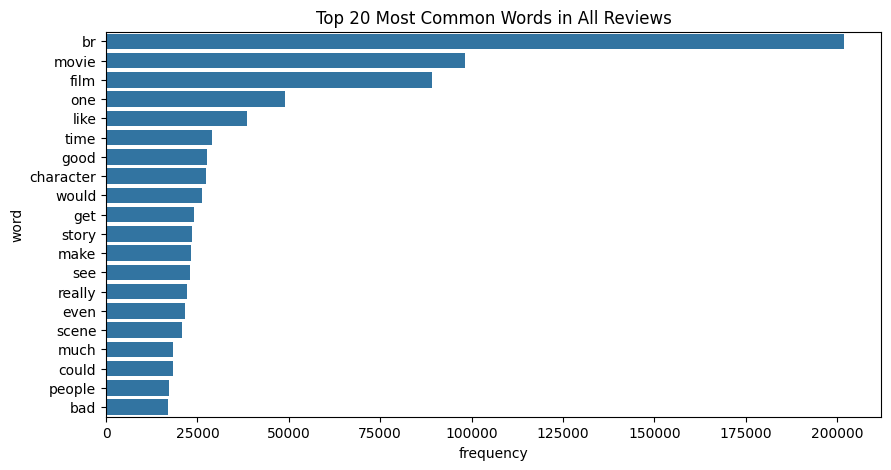

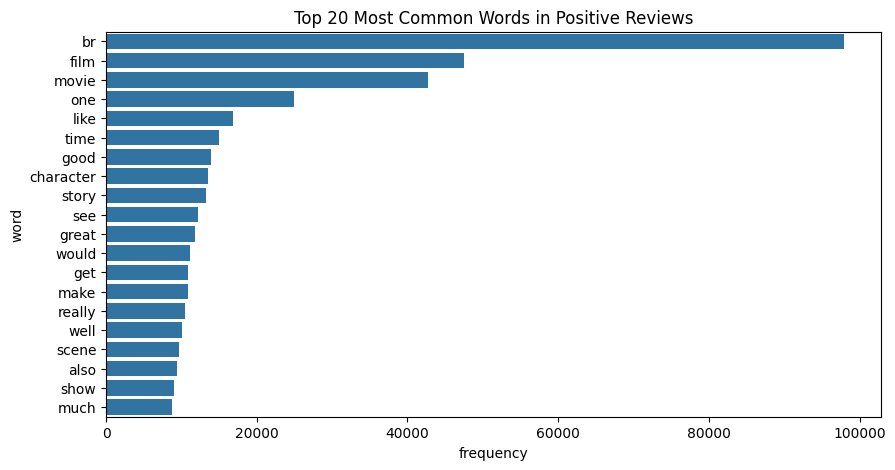

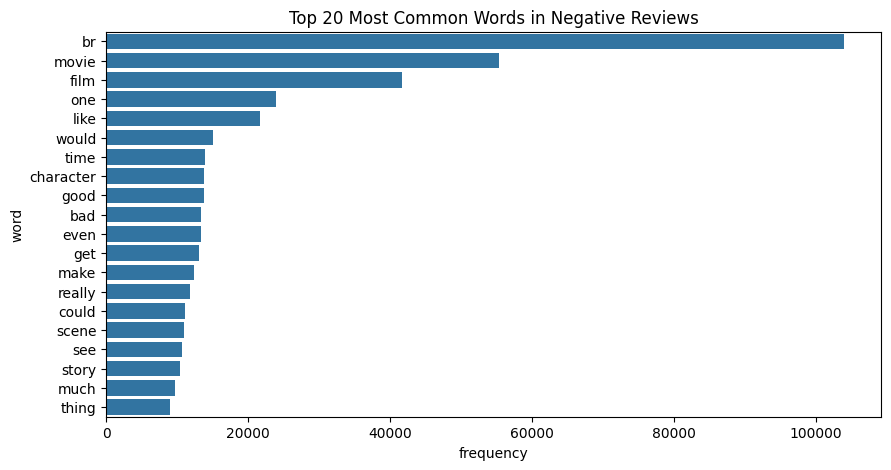

In [10]:
# Generate the word frequency
plot_word_frequency(all_reviews, "All Reviews")
plot_word_frequency(positive_text, "Positive Reviews")
plot_word_frequency(negative_text, "Negative Reviews")

#### All Reviews
The word frequency plot for all reviews shows generic terms, such as "movie," "film," "one," "like," "good," "would," and "even." Weirdly, the word "br" is the most frequent word, this could be due to HTML tags or broken text that have not been cleaned out. These words do not provide clear insight into the reviews, and the "br" needs to be removed.

#### Positive Reviews
Positive reviews highlight words such as "like", "good", "great", and "love", which corresponds with the class "positive".

#### Negative Reviews
Negative reviews contain words like "bad", "like", and "good". Though some phrases overlap with positive reviews, "bad" is a preety good negative sentiment indicator.

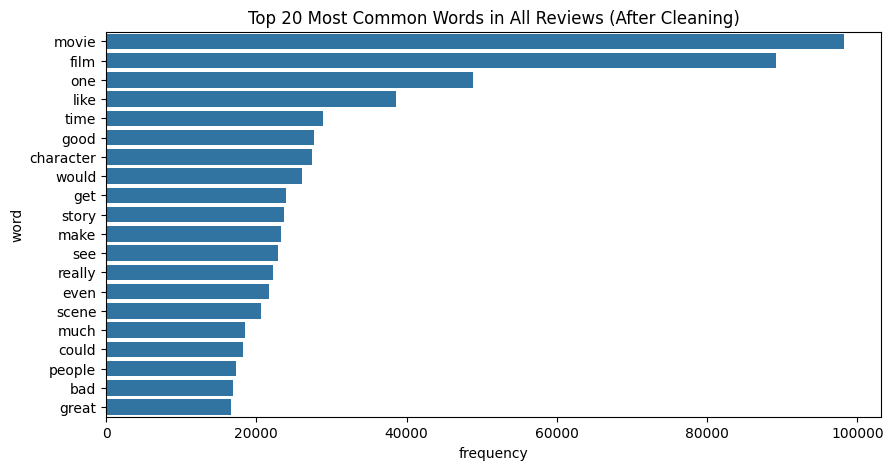

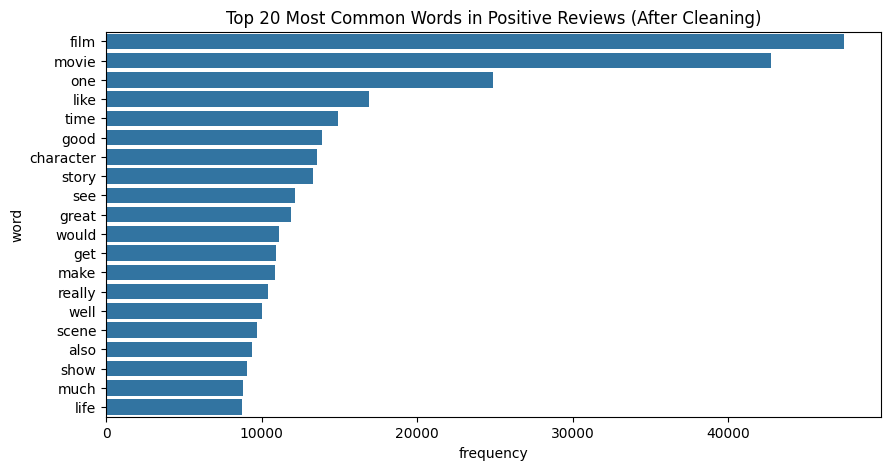

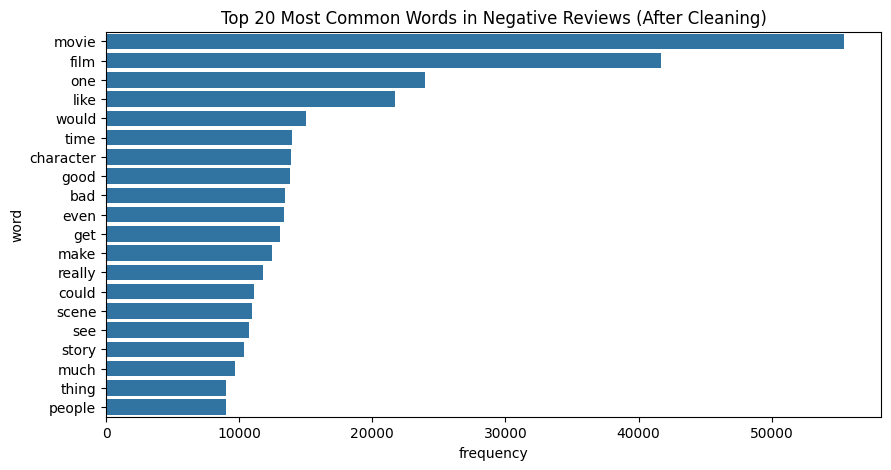

In [11]:
# Remove 'br' tags to make the data cleaner
all_reviews = remove_br(all_reviews)
positive_text = remove_br(positive_text)
negative_text = remove_br(negative_text)

# Generate the word frequency plot after removing 'br'
plot_word_frequency(all_reviews, "All Reviews (After Cleaning)")
plot_word_frequency(positive_text, "Positive Reviews (After Cleaning)")
plot_word_frequency(negative_text, "Negative Reviews (After Cleaning)")


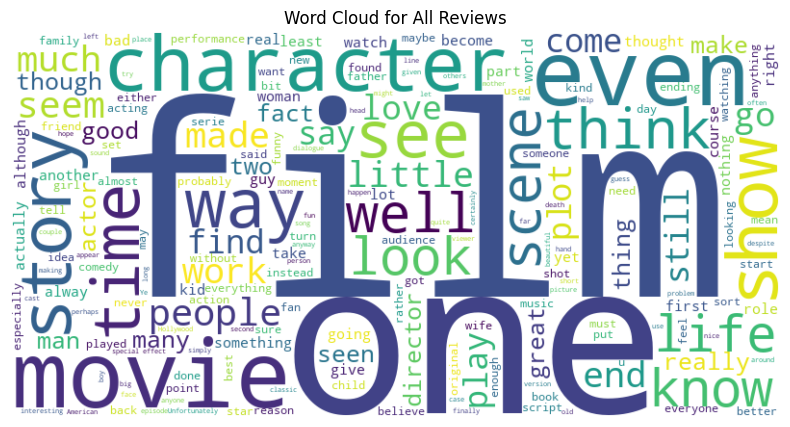

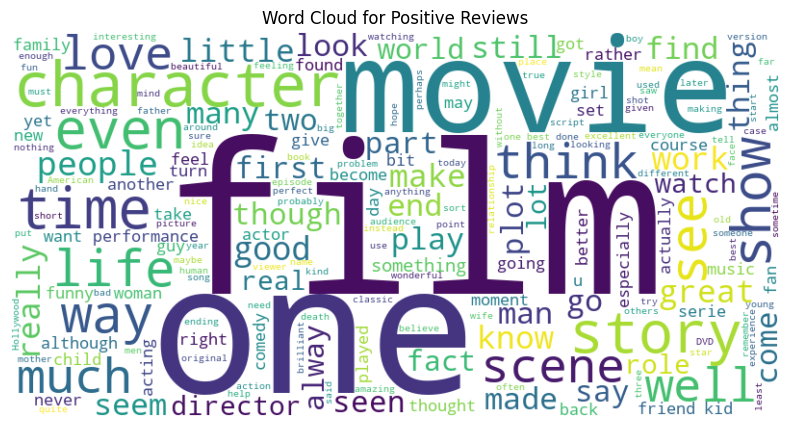

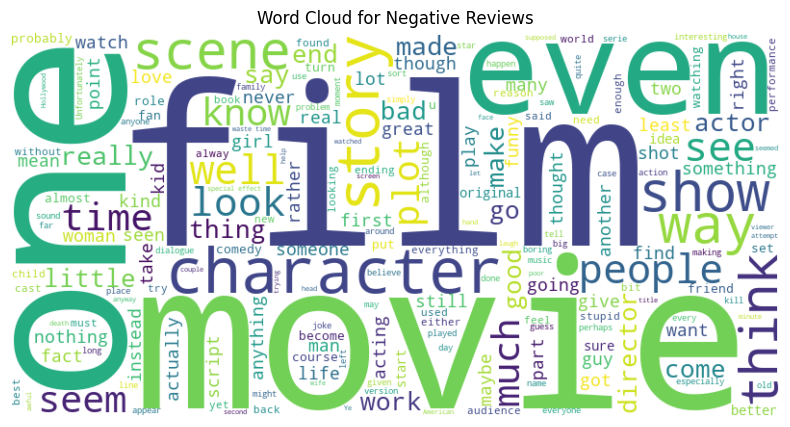

In [12]:
# Generate Wordcloud
generate_word_cloud(all_reviews, "All Reviews")
generate_word_cloud(positive_text, "Positive Reviews")
generate_word_cloud(negative_text, "Negative Reviews")

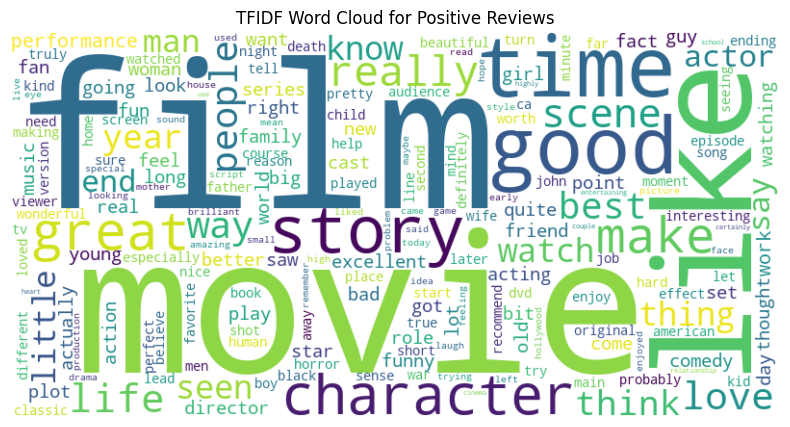

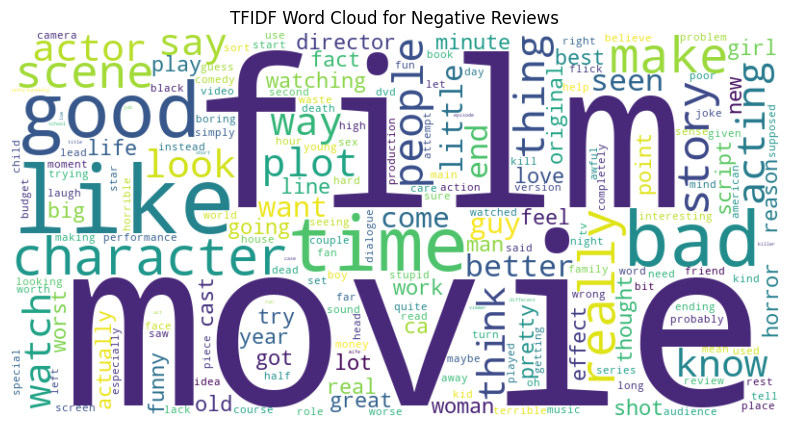

In [24]:
# generate world cloud with TFIDF vectorization
TFIDF_wordcloud(positive_text, "Positive Reviews")
TFIDF_wordcloud(negative_text, "Negative Reviews")

### TASK 4: Vectorize the Training Data (10 points)
Transform the raw text data into vectors. You are encouraged but not required to try complex options.

Simple Options:
1. Count Vectors
2. Binary Vectors
3. TFIDF Vectors

Example Complex Options:
1. Word2Vec (gensim.models.Word2Vec)
2. Transformers such as BERT and GPT 

Example References:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
https://pypi.org/project/transformers/

In [14]:
# Spilt the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['class'], test_size=0.2, random_state=42)


In [15]:
# Count vector

# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# vectorize training and testing set
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [16]:
# TFIDF vector

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# vectorize training and testing set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [17]:
# Word2Vec

# Tokenize text for Word2Vec
tokenized_train = [review.split() for review in X_train]
tokenized_test = [review.split() for review in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to
def get_average_word2vec(tokens_list, model, vector_size):
    """ Create average Word2Vec vector. """
    
    vectors = [model.wv[word] for word in tokens_list if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Vectorize the training and testing data
X_train_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_train])
X_test_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_test])


### TASK 6: Train and Tune Models (10 points)
Train and tune multiple models (3+). Try out different vectors. Perform cross-validation to find the optimal model for each kind.

Example Models to Consider:
https://scikit-learn.org/stable/modules/naive_bayes.html

In [18]:
# Handle GaussianNB separately to accommodate limited memory

def partial_fit_gaussian_nb(vectorized_data, labels, batch_size=1000):
    """
    Incrementally fit GaussianNB using partial fit with smaller batches.
    
    Expected Arguments:
    vectorized_data: The full dataset already vectorized.
    labels: The target values (categories or classes).
    batch_size: Size of the batches for partial fit.
    
    Outputs:
    Returns the fitted GaussianNB model.
    """
    model = GaussianNB()
    unique_labels = np.unique(labels)

    # Convert labels to numpy array
    labels = np.array(labels)
    
    for start in range(0, vectorized_data.shape[0], batch_size):
        end = min(start + batch_size, vectorized_data.shape[0])
        X_batch = vectorized_data[start:end].toarray()
        y_batch = labels[start:end]
        model.partial_fit(X_batch, y_batch, classes=unique_labels)
    
    return model

def predict_in_batches(model, X_test, batch_size=1000):
    """
    Predict in smaller batches to handle large data sizes.
    
    Expected Arguments:
    model: The trained GaussianNB model.
    X_test: The test data that needs to be predicted.
    batch_size: Size of the batches for prediction.
    
    Outputs:
    Returns the combined predictions for the test data.
    """
    predictions = []
    for start in range(0, X_test.shape[0], batch_size):
        end = min(start + batch_size, X_test.shape[0])
        X_batch = X_test[start:end].toarray()
        batch_predictions = model.predict(X_batch)
        predictions.extend(batch_predictions)
    
    return np.array(predictions)

In [19]:
# Train and tune models

def train_and_evaluate_model(vector_name, vectorized_data, labels, model, batch_size=1000):
    """ 
    Train and validate models with different vector types, including Count Vectors, TF-IDF, and Word2Vec.

    Expected Arguments:
    vector_name: A string that stores the type of vector. Ex: "Count Vector"
    vectorized_data: The training part of the dataset that is already vectorized.
    labels: The target values such as categories or classes. (What the classifier will predict and match against)
    model: The machine learning classifier you wish to use. (e.g., MultinomialNB, BernoulliNB, GaussianNB)
    batch_size: Size of the batches for partial fit.

    Outputs:
    Prints the model name and evaluation metrics including accuracy, precision, recall, and F1-score.
    """
    # Skip MultinomialNB with Word2Vec due to negative values
    if isinstance(model, MultinomialNB) and vector_name == "Word2Vec":
        print(f"Skipping {model.__class__.__name__} with {vector_name} due to incompatibility.")
        return

    kf = KFold(n_splits=5)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Convert labels to numpy array for compatibility with KFold
    labels = np.array(labels)

    # Split and process the dataset in batches
    for train_index, test_index in kf.split(vectorized_data):
        X_train, X_test = vectorized_data[train_index], vectorized_data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Separate handling for GaussianNB to accommodate limited memory 
        # Convert to dense format if using GaussianNB and the data is sparse like count vector and TFIDF
        if isinstance(model, GaussianNB) and issparse(vectorized_data):
            model = partial_fit_gaussian_nb(X_train, y_train, batch_size)
            predictions = predict_in_batches(model, X_test, batch_size)
        else:
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
                
        accuracy_scores.append(accuracy_score(y_test, predictions))
        precision_scores.append(precision_score(y_test, predictions, average='weighted'))
        recall_scores.append(recall_score(y_test, predictions, average='weighted'))
        f1_scores.append(f1_score(y_test, predictions, average='weighted'))
    
    accuracy = np.mean(accuracy_scores)
    precision = np.mean(precision_scores)
    recall = np.mean(recall_scores)
    f1 = np.mean(f1_scores)
       
    print(f"Model: {model.__class__.__name__}")
    print(f"Vector Type: {vector_name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")


In [20]:
# Store Vectorized Data
vectorized_data = {
    "Count Vector": (X_train_count, X_test_count),
    "TF-IDF Vector": (X_train_tfidf, X_test_tfidf),
    "Word2Vec": (X_train_word2vec, X_test_word2vec)
}

# Define classifiers (the model types)
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'GaussianNB': GaussianNB()
}

# Train and evaluate models
for vector_name, (X_train, X_test) in vectorized_data.items():
    for model in classifiers:
        train_and_evaluate_model(vector_name, X_train, y_train, classifiers[model], 100)
        print("--------------")

Model: MultinomialNB
Vector Type: Count Vector
Accuracy: 0.85
Precision: 0.86
Recall: 0.85
F1-Score: 0.85
--------------
Model: BernoulliNB
Vector Type: Count Vector
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-Score: 0.85
--------------
Model: GaussianNB
Vector Type: Count Vector
Accuracy: 0.63
Precision: 0.65
Recall: 0.63
F1-Score: 0.62
--------------
Model: MultinomialNB
Vector Type: TF-IDF Vector
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-Score: 0.86
--------------
Model: BernoulliNB
Vector Type: TF-IDF Vector
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1-Score: 0.85
--------------
Model: GaussianNB
Vector Type: TF-IDF Vector
Accuracy: 0.64
Precision: 0.65
Recall: 0.64
F1-Score: 0.63
--------------
Skipping MultinomialNB with Word2Vec due to incompatibility.
--------------
Model: BernoulliNB
Vector Type: Word2Vec
Accuracy: 0.64
Precision: 0.64
Recall: 0.64
F1-Score: 0.64
--------------
Model: GaussianNB
Vector Type: Word2Vec
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1-Sco

#### Result
I trained and tuned several models using different vectorization techniques. Specifically, I used MultinomialNB, BernoulliNB, and GaussianNB classifiers, and tested them with Count Vector, TF-IDF Vector, and Word2Vec representations. The models were evaluated using cross-validation and several evluation metrics such as accuracy, precision, recall, and F1-score.

- **MultinomialNB** performed well with both Count Vector and TF-IDF Vector, with TF-IDF showing a slight edge. Did not try Word2Vec due to incompability - Word2Vec produced negative values while MultinomialNB only accepts non negative values.
- **BernoulliNB** also showed strong performance with Count Vector and TF-IDF Vector, but struggled with Word2Vec, achieving only 0.64 accuracy.
- **GaussianNB** did not perform well with any of the vector types, having accuracies between 0.63 and 0.67, with Word2Vec being slightly better.

#### Conclusion
Count Vector and TF-IDF Vector are effective with MultinomialNB and BernoulliNB for text classification. Word2Vec did not perform well with any model, indicating it might not be suitable for this specific text classification task.

For the final testing, I will use TFIDF for both MultinomialNB and BernoulliNB. And use Word2Vec for GaussianNB.

### TASK 7: Load, Explore, Preprocess, Vectorize Test Data (5 points)
Explore, preprocess, and vectorize the test data **using the exact same models as the training set**. 

The test dataset will be published after students all write their movie reviews.

The test dataset will have the suffix 2
Ex: df2, all_reviews2...

In [33]:
# merge individual .txt files into one .csv
# Because this will be posted on GitHub, I have preprocessed the files.
# Now the file name is just an ID, prefix "p" for positive reviews, "n" for negative
# The original filenames with students' names are stored elsewhere and not on GitHub.

import os

def read_reviews(folder, sentiment):
    """
    Reads all text files in a given folder and creates a list of dictionaries with file information.
    
    Args:
        folder (str): The path to the folder containing the text files.
        sentiment (str): The sentiment label (e.g., 'positive', 'negative') to assign to each review.
    
    Returns:
        list: A list of dictionaries, each containing 'ID', 'review', and 'sentiment' keys.
    """
    reviews = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
                review = file.read().strip()  # Read the entire file content, including multi-line text
                reviews.append({'ID': filename, 'review': review, 'sentiment': sentiment})
    return reviews

# Read positive reviews
positive_folder = 'test data/positive_reviews'
positive_reviews2 = read_reviews(positive_folder, 'positive')

# Read negative reviews
negative_folder = 'test data/negative_reviews'
negative_reviews2 = read_reviews(negative_folder, 'negative')

# Combine reviews
all_reviews2 = positive_reviews + negative_reviews

# Create DataFrame
df2 = pd.DataFrame(all_reviews)

# Save to CSV
df2.to_csv('test_dataset_reviews.csv', index=False)

print("Reviews have been successfully saved to test_dataset_reviews.csv")

Reviews have been successfully saved to test_dataset_reviews.csv


In [34]:
# Display the first few rows of the dataset to check it's loaded correctly
print(df2.head())

         ID                                             review sentiment
0  p101.txt  Encanto  \nI like Encanto because of its great...  positive
1  p102.txt  Grandma and Her Ghosts (魔法阿媽)  \nGrandma and H...  positive
2  p103.txt  Nope (2022)  \nI wasn’t a fan of Nope. The plo...  positive
3  p104.txt  ﻿The film Lone Survivor is a wonderful piece o...  positive
4  p105.txt  ﻿Movie Review: When Harry Met Sally\n \nWhen H...  positive


In [35]:
# Check for missing values 
missing_values = df2.isnull().sum() 
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 ID           0
review       0
sentiment    0
dtype: int64


#### Create a binary target column named "class"
"negative" -> 0
"positive" -> 1

In [36]:
# create the 'class' column by apply the function to the 'sentiment' column
df2['class'] = df2['sentiment'].apply(sentiment_to_class)

# Check result
print(df2.head())

         ID                                             review sentiment  \
0  p101.txt  Encanto  \nI like Encanto because of its great...  positive   
1  p102.txt  Grandma and Her Ghosts (魔法阿媽)  \nGrandma and H...  positive   
2  p103.txt  Nope (2022)  \nI wasn’t a fan of Nope. The plo...  positive   
3  p104.txt  ﻿The film Lone Survivor is a wonderful piece o...  positive   
4  p105.txt  ﻿Movie Review: When Harry Met Sally\n \nWhen H...  positive   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  


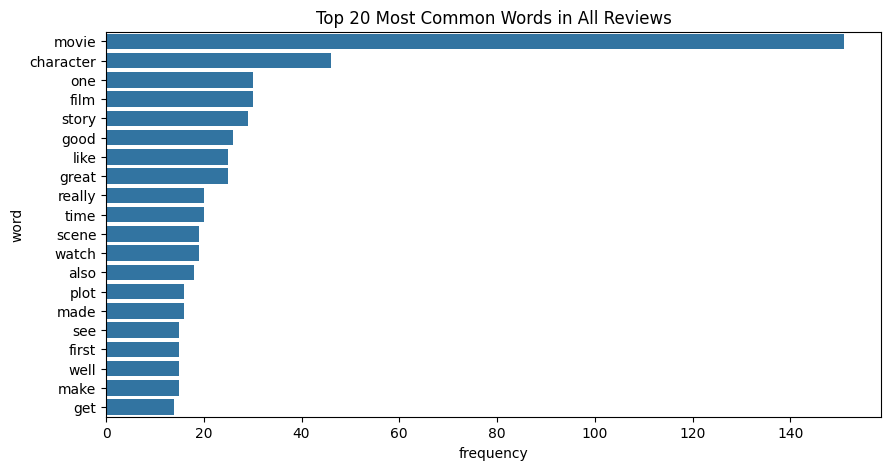

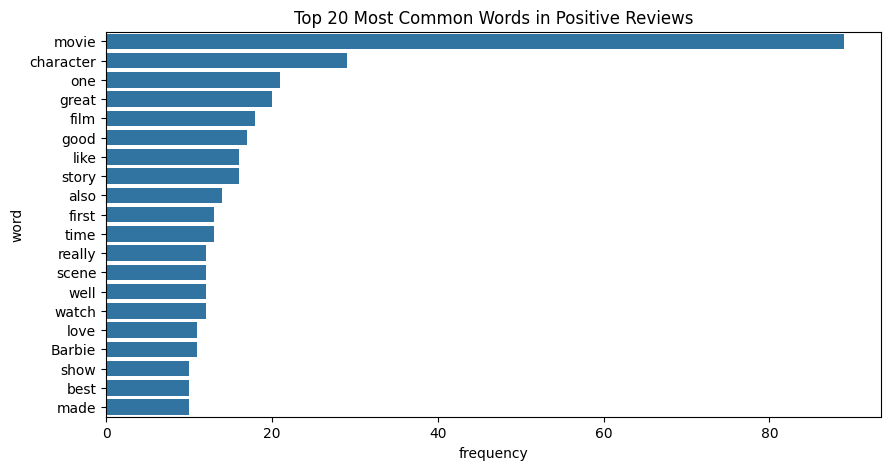

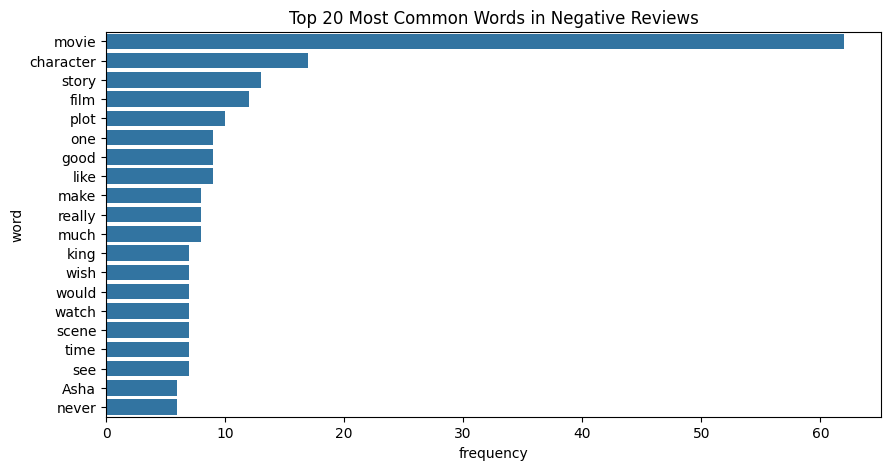

In [37]:
# Combine and preprocess text
all_reviews2 = combine_and_preprocess_text(df_test, 'review')
positive_text2 = combine_and_preprocess_text(df_test[df_test['class'] == 1], 'review')
negative_text2 = combine_and_preprocess_text(df_test[df_test['class'] == 0], 'review')

# Generate the word frequency plot
plot_word_frequency(all_reviews2, "All Reviews")
plot_word_frequency(positive_text2, "Positive Reviews")
plot_word_frequency(negative_text2, "Negative Reviews")

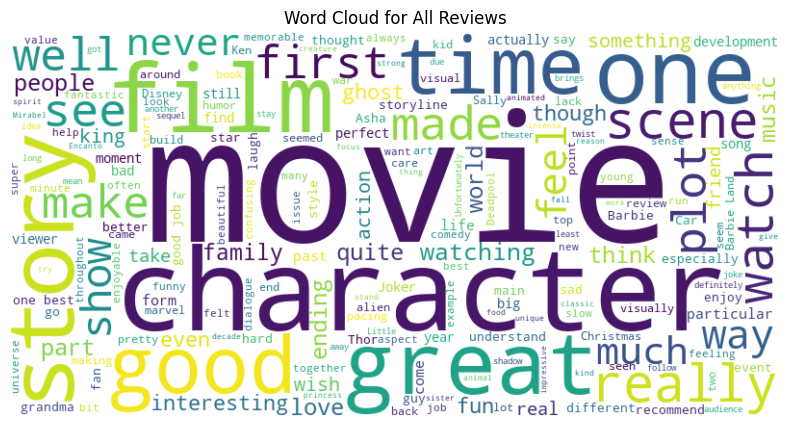

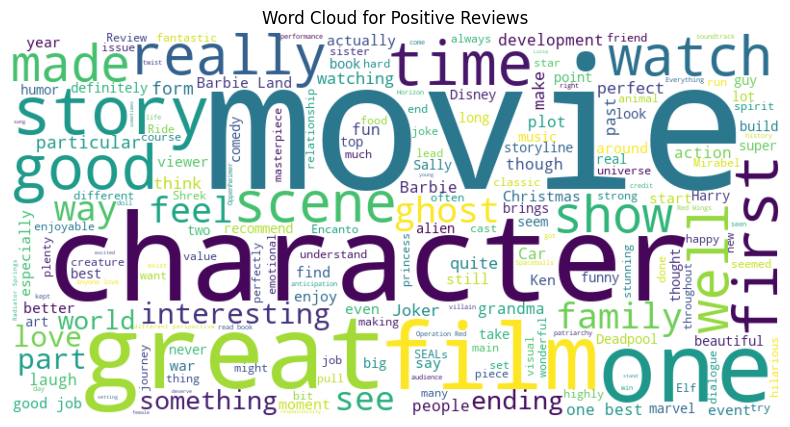

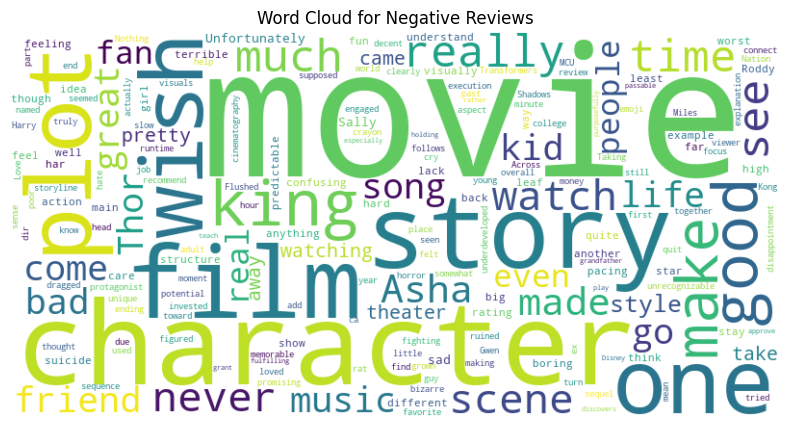

In [38]:
# Generate Wordcloud
generate_word_cloud(all_reviews2, "All Reviews")
generate_word_cloud(positive_text2, "Positive Reviews")
generate_word_cloud(negative_text2, "Negative Reviews")

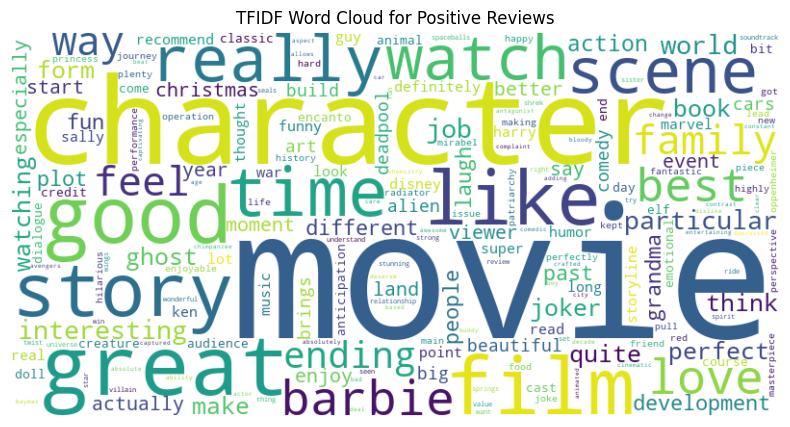

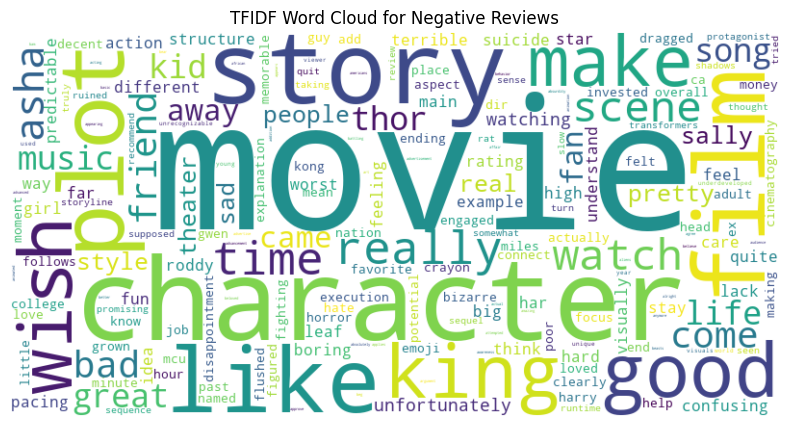

In [39]:
# generate world cloud with TFIDF vectorization
TFIDF_wordcloud(positive_text2, "Positive Reviews")
TFIDF_wordcloud(negative_text2, "Negative Reviews")

In [16]:
# TFIDF vector
# USe the same TF-IDF Vectorizer that the training dataset used

# vectorize new testing set
new_test_tfidf = tfidf_vectorizer.transform(all_reviews2)

In [17]:
# Word2Vec

# Tokenize text for Word2Vec
tokenized_new_test = [all_reviews2.split()]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to get_average_word2vec already defined when vectorizing the training data

# Vectorize the new testing data
new_test_word2vec = np.array([get_average_word2vec(review, word2vec_model, 100) for review in tokenized_new_test])


In [ ]:
# Make predictions on the new test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_predict(models_vectors, y_train, y_new_test, batch_size=1000):
    """
    Train and validate models with different vector types, and predict on new test data.

    Args:
        models_vectors (dict): A dictionary pairing models with vectorizers and their vectorized data.
        y_train (list): The training data labels.
        y_new_test (list): The new test data labels.
        batch_size (int): Size of the batches for partial fit.
    
    Outputs:
    Prints the model name and evaluation metrics including accuracy, precision, recall, and F1-score.
    """

    for name, (model, (X_train_vec, X_test_vec, new_test_vec)) in models_vectors.items():
        # Perform cross-validation
        kf = KFold(n_splits=5)
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        labels = np.array(y_train)
        for train_index, test_index in kf.split(X_train_vec):
            X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
            y_train_cv, y_test_cv = labels[train_index], labels[test_index]

            # Handle GaussianNB separately to avoid memory issues
            if isinstance(model, GaussianNB) and issparse(X_train_vec):
                model = partial_fit_gaussian_nb(X_train_cv, y_train_cv, batch_size)
                predictions = predict_in_batches(model, X_test_cv, batch_size)
            else:
                model.fit(X_train_cv, y_train_cv)
                predictions = model.predict(X_test_cv)

            accuracy_scores.append(accuracy_score(y_test_cv, predictions))
            precision_scores.append(precision_score(y_test_cv, predictions, average='weighted'))
            recall_scores.append(recall_score(y_test_cv, predictions, average='weighted'))
            f1_scores.append(f1_score(y_test_cv, predictions, average='weighted'))

        accuracy = np.mean(accuracy_scores)
        precision = np.mean(precision_scores)
        recall = np.mean(recall_scores)
        f1 = np.mean(f1_scores)

        print(f"Model: {model.__class__.__name__}")
        print(f"Vector Type: {name}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1-Score: {f1:.2f}")
        print("    --------")

        # Make predictions on the new test data
        new_test_pred = model.predict(new_test_vec)
        accuracy_new_test = accuracy_score(y_new_test, new_test_pred)
        precision_new_test = precision_score(y_new_test, new_test_pred, average='weighted')
        recall_new_test = recall_score(y_new_test, new_test_pred, average='weighted')
        f1_new_test = f1_score(y_new_test, new_test_pred, average='weighted')
        
        print(f"New Test Data Performance for {name}:")
        print(f"Accuracy: {accuracy_new_test:.2f}")
        print(f"Precision: {precision_new_test:.2f}")
        print(f"Recall: {recall_new_test:.2f}")
        print(f"F1-Score: {f1_new_test:.2f}")
        print("---------------------")

    return results

# Pair up the classifiers and their corresponding vectorized data
classifiers_vectorization = {
    'MultinomialNB_TfidfVector': (MultinomialNB(), (X_train_tfidf, X_test_tfidf, new_test_tfidf)),
    'BernoulliNB_TfidfVector': (BernoulliNB(), (X_train_tfidf, X_test_tfidf, new_test_tfidf)),
    'GaussianNB_Word2Vec': (GaussianNB(), (X_train_word2vec, X_test_word2vec, new_test_word2vec))
}

# MAke sure new_test_review is compatable
if isinstance(new_test_reviews, str):
    new_test_reviews = [new_test_reviews]

# Assuming you have the true labels for the new test data
y_new_test = df2['class']

# Train models and predict on new test data
train_and_predict(classifiers_vectorization, y_train, y_new_test)

# Use the results dictionary for further analysis or processing


### TASK 8: Test the Data and Analyze the Results (10 points)
For each model, compute accuracy, precision, recall, f1-score, and the confusion matrix. 

Compare the model performances based on performance on the testing.